In [21]:
import gc
import time
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline

## Load The Data

In [22]:
def load_data(path_data):
    priors=pd.read_csv(path_data+'order_products__prior.csv',
                      dtype={
                          'order_id':np.int32,
                          'product_id': np.uint16,
                          'add_to_cart_order': np.int16,
                          'reordered': np.int8})
    

    train=pd.read_csv(path_data+'order_products__train.csv',
                     dtype={'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
# the order number of a specific user
    orders=pd.read_csv(path_data+'orders.csv',
                      dtype={ 
                              'order_id': np.int32,
                              'user_id': np.int64,
                              'eval_set': 'category',
                              'order_number': np.int16,
                              'order_dow': np.int8,
                              'order_hour_of_day': np.int8,
                              'days_since_prior_order': np.float32})

# products
    products = pd.read_csv(path_data + 'products.csv', 
                           dtype={
                                'product_id': np.uint32,
                                'order_id': np.int32,
                                'aisle_id': np.uint8,
                                'department_id': np.uint8},
                             
                               usecols=['product_id', 'aisle_id', 'department_id'])
    aisles = pd.read_csv(path_data + "aisles.csv")
    departments = pd.read_csv(path_data + "departments.csv")
    sample_submission = pd.read_csv(path_data + "sample_submission.csv")

    return priors, train, orders, products, aisles, departments, sample_submission

In [23]:
path_data='../DataArtist/instacart/'
priors, train, orders, products, aisles, departments, sample_submission=load_data(path_data)

## Create a tick_tock class

In [24]:
class tick_tock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))

In [25]:
def ka_add_groupby_features_1_vs_n(df, group_columns_list, agg_dict, only_new_feature=True):
    '''Create statistical columns, group by [N columns] and compute stats on [N column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       agg_dict: python dictionary

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       {real_column_name: {your_specified_new_column_name : method}}
       agg_dict = {'user_id':{'prod_tot_cnts':'count'},
                   'reordered':{'reorder_tot_cnts_of_this_prod':'sum'},
                   'user_buy_product_times': {'prod_order_once':lambda x: sum(x==1),
                                              'prod_order_more_than_once':lambda x: sum(x==2)}}
       ka_add_stats_features_1_vs_n(train, ['product_id'], agg_dict)
    '''
    with tick_tock("add stats features"):
        try:
            if type(group_columns_list) == list:
                pass
            else:
                raise TypeError(k + "should be a list")
        except TypeError as e:
            print(e)
            raise
            
# copy a new dataframe
        df_new = df.copy()
# make the dataframe group by an assigned list
        grouped = df_new.groupby(group_columns_list)
# agg dict
        the_stats = grouped.agg(agg_dict)
        the_stats.columns = the_stats.columns.droplevel(0)
        the_stats.reset_index(inplace=True)
        if only_new_feature:
            df_new = the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
            
    return df_new

In [26]:
def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    '''Create statistical columns, group by [N columns] and compute stats on [1 column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       target_columns_list: list_like
          column you want to compute stats, need to be a list with only one element
       methods_list: list_like
          methods that you want to use, all methods that supported by groupby in Pandas

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       ka_add_stats_features_n_vs_1(train, group_columns_list=['x0'], target_columns_list=['x10'])
    '''
    with tick_tock("add stats features", verbose):
        dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

        for k, v in dicts.items():
            try:
                if type(v) == list:
                    pass
                else:
                    raise TypeError(k + "should be a list")
            except TypeError as e:
                print(e)
                raise

        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
        if keep_only_stats:
            return the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
        return df_new

## Product Part DataFrame

In [27]:
# Products information ----------------------------------------------------------------
# add order information to priors set
priors_orders_detail = orders.merge(right=priors, how='inner', on='order_id')

# create new variables
# _user_buy_product_times: 
priors_orders_detail.loc[:,'_user_buy_product_times'] = priors_orders_detail.groupby(['user_id', 'product_id']).cumcount() + 1
# _prod_tot_cnts: 
# _reorder_tot_cnts_of_this_prod: 
### 
# _prod_order_once: 
# _prod_order_more_than_once: 
agg_dict = {'user_id':{'_prod_tot_cnts':'count'}, 
            'reordered':{'_prod_reorder_tot_cnts':'sum'}, 
            '_user_buy_product_times': {'_prod_buy_first_time_total_cnt':lambda x: sum(x==1),
                                        '_prod_buy_second_time_total_cnt':lambda x: sum(x==2)}}
prd = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['product_id'], agg_dict)

# _prod_reorder_prob: 
# _prod_reorder_ratio: 
prd['_prod_reorder_prob'] = prd._prod_buy_second_time_total_cnt / prd._prod_buy_first_time_total_cnt
prd['_prod_reorder_ratio'] = prd._prod_reorder_tot_cnts / prd._prod_tot_cnts
prd['_prod_reorder_times'] = 1 + prd._prod_reorder_tot_cnts / prd._prod_buy_first_time_total_cnt

add stats features begin ......
add stats features end ......
time lapsing 274.3544704914093 s 



In [28]:
prd.head()

,product_id,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_buy_first_time_total_cnt,_prod_buy_second_time_total_cnt,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times
0,1,1852,1136.0,716,276,0.385475,0.613391,2.586592
1,2,90,12.0,78,8,0.102564,0.133333,1.153846
2,3,277,203.0,74,36,0.486486,0.732852,3.743243
3,4,329,147.0,182,64,0.351648,0.446809,1.807692
4,5,15,9.0,6,4,0.666667,0.600000,2.500000


## User Part

In [29]:
# _user_total_orders: 
# _user_sum_days_since_prior_order: 
# _user_mean_days_since_prior_order: 
agg_dict_2 = {'order_number':{'_user_total_orders':'max'},
              'days_since_prior_order':{'_user_sum_days_since_prior_order':'sum', 
                                        '_user_mean_days_since_prior_order': 'mean'}}
users= ka_add_groupby_features_1_vs_n(orders[orders.eval_set == 'prior'], ['user_id'], agg_dict_2)

add stats features begin ......
add stats features end ......
time lapsing 1.0578711032867432 s 



In [30]:
# _user_reorder_ratio: reorder
# _user_total_products: 
# _user_distinct_products: 
agg_dict_3 = {'reordered':
              {'_user_reorder_ratio': 
               lambda x: sum(priors_orders_detail.ix[x.index,'reordered']==1)/
                         sum(priors_orders_detail.ix[x.index,'order_number'] > 1)},
              'product_id':{'_user_total_products':'count', 
                            '_user_distinct_products': lambda x: x.nunique()}}
us = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['user_id'], agg_dict_3)
users = users.merge(us, how='inner')

add stats features begin ......
add stats features end ......
time lapsing 1385.8060734272003 s 



In [31]:
users['_user_average_basket'] = users._user_total_products / users._user_total_orders

us = orders[orders.eval_set != "prior"][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
us.rename(index=str, columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)

users = users.merge(us, how='inner')

In [32]:
users.head()

,user_id,_user_total_orders,_user_sum_days_since_prior_order,_user_mean_days_since_prior_order,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_average_basket,order_id,eval_set,time_since_last_order
0,1,10,176.0,19.555555,0.759259,59,18,5.900000,1187899,train,14.0
1,2,14,198.0,15.230769,0.510989,195,102,13.928571,1492625,train,30.0
2,3,12,133.0,12.090909,0.705128,88,33,7.333333,2774568,test,11.0
3,4,5,55.0,13.750000,0.071429,18,17,3.600000,329954,test,30.0
4,5,4,40.0,13.333333,0.538462,37,23,9.250000,2196797,train,6.0


## Database Part

In [33]:
# _up_order_count: 
# _up_first_order_number: 
# _up_last_order_number: 
# _up_average_cart_position: 
agg_dict_4 = {'order_number':{'_up_order_count': 'count', 
                              '_up_first_order_number': 'min', 
                              '_up_last_order_number':'max'}, 
              'add_to_cart_order':{'_up_average_cart_position': 'mean'}}

data = ka_add_groupby_features_1_vs_n(df=priors_orders_detail, 
                                                      group_columns_list=['user_id', 'product_id'], 
                                                      agg_dict=agg_dict_4)

data = data.merge(prd, how='inner', on='product_id').merge(users, how='inner', on='user_id')

add stats features begin ......
add stats features end ......
time lapsing 67.91782546043396 s 



In [34]:
data['_up_order_rate'] = data._up_order_count / data._user_total_orders
data['_up_order_since_last_order'] = data._user_total_orders - data._up_last_order_number
data['_up_order_rate_since_first_order'] = data._up_order_count / (data._user_total_orders - data._up_first_order_number + 1)

# add user_id to train set
train = train.merge(right=orders[['order_id', 'user_id']], how='left', on='order_id')
data = data.merge(train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

# release Memory
# del train, prd, users
# gc.collect()
# release Memory
del priors_orders_detail, orders
gc.collect()

306

In [35]:
data.head()

,user_id,product_id,_up_order_count,_up_first_order_number,_up_last_order_number,_up_average_cart_position,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_buy_first_time_total_cnt,_prod_buy_second_time_total_cnt,...,_user_total_products,_user_distinct_products,_user_average_basket,order_id,eval_set,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order,reordered
0,1,196,10,1,10,1.400000,35791,27791.0,8000,4660,...,59,18,5.9,1187899,train,14.0,1.0,0,1.000000,1.0
1,1,10258,9,2,10,3.333333,1946,1389.0,557,308,...,59,18,5.9,1187899,train,14.0,0.9,0,1.000000,1.0
2,1,10326,1,5,5,5.000000,5526,3603.0,1923,1003,...,59,18,5.9,1187899,train,14.0,0.1,5,0.166667,NaN
3,1,12427,10,1,10,3.300000,6476,4797.0,1679,889,...,59,18,5.9,1187899,train,14.0,1.0,0,1.000000,NaN
4,1,13032,3,2,10,6.333333,3751,2465.0,1286,617,...,59,18,5.9,1187899,train,14.0,0.3,0,0.333333,1.0


### Fit a XGboost Model

In [36]:
import xgboost

train=data.loc[data.eval_set=="train",:]
train.drop(['eval_set','user_id','product_id','order_id'],axis=1,inplace=True)
# fill the nan with the values zero
train.loc[:,'reordered']=train.reordered.fillna(0)

c:\users\thinkpad\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\thinkpad\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [37]:
test = data.loc[data.eval_set == "test",:]

In [38]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train.drop('reordered',axis=1),train.reordered,test_size=0.9,random_state=42)

In [39]:
d_train=xgboost.DMatrix(X_train,y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}


[0]	train-logloss:0.625812
[10]	train-logloss:0.335234
[20]	train-logloss:0.267928
[30]	train-logloss:0.250515
[40]	train-logloss:0.245745
[50]	train-logloss:0.244161
[60]	train-logloss:0.243361
[70]	train-logloss:0.242898


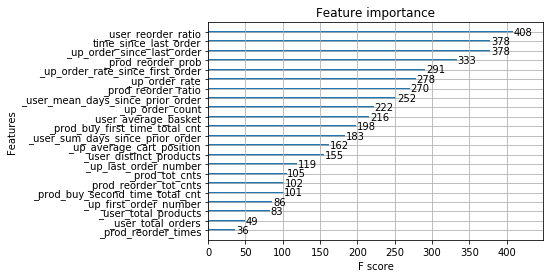

In [41]:
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)
plt.show()

In [ ]:
d_test = xgboost.DMatrix(test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))
test.loc[:,'reordered'] = (bst.predict(d_test) > 0.21).astype(int)
test.loc[:, 'product_id'] = test.product_id.astype(str)
submit = ka_add_groupby_features_n_vs_1(test[test.reordered == 1], 
                                               group_columns_list=['order_id'],
                                               target_columns_list= ['product_id'],
                                               methods_list=[lambda x: ' '.join(set(x))], keep_only_stats=True)
submit.columns = sample_submission.columns.tolist()
submit_final = sample_submission[['order_id']].merge(submit, how='left').fillna('None')
submit_final.to_csv("v1.csv", index=False)